In [1]:
'''
构造后门样本的新思路：
1.训练足够好的Encoder与Decoder
2.利用Encoder将选定的carrier编码成特征向量f
3.向特征向量f中加入key得到f'
4.利用Decoder新的特征向量f'生成后门样本
改进：
1.只要一个AE,训练成本降低
2.样本是正常的人脸,杜绝了被噪声过滤等常规攻击抹去的可能性
3.提供AE+Key可复现后门样本的生成,提供了身份认证
'''

"\n构造后门样本的新思路：\n1.训练足够好的Encoder与Decoder\n2.利用Encoder将选定的carrier编码成特征向量f\n3.向特征向量f中加入key得到f'\n4.利用Decoder新的特征向量f'生成后门样本\n改进：\n1.只要一个AE,训练成本降低\n2.样本是正常的人脸,杜绝了被噪声过滤等常规攻击抹去的可能性\n3.提供AE+Key可复现后门样本的生成,提供了身份认证\n"

In [2]:
from dataset import Dataset
import torch
from torch import nn 
import torch.optim as optim
from torch.utils import data
import time
from config import Config

In [3]:
train_root = Config.web_root
train_list = Config.AE_train_list
device = torch.device("cuda:3")

train_dataset = Dataset(train_root, train_list, phase='train', input_shape=(1,128,128))
dataset1, dataset2, dataset3 = data.random_split(
    train_dataset, [10000, 15000, 25000])

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 2*16, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(2*16, 2*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*16, 3*16, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(3*16, 3*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(3*16, 4*16, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(4*16, 4*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(4*16, 5*16, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.GELU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(5*16*16, 512)  # 特征向量：dim=512
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()    

        self.linear = nn.Sequential(
            nn.Linear(512, 5*16*16),
            nn.GELU()
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(5*16, 4*16, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.GELU(),
            nn.Conv2d(4*16, 4*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(4*16, 3*16, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(3*16, 3*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(3*16, 2*16, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(2*16, 2*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*16, 16, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [6]:
En = Encoder()
De = Decoder()
En.to(device)
De.to(device)

criterion = nn.MSELoss(reduction="none")
optimizer = optim.Adam([{'params': En.parameters()}, {'params': De.parameters()}], lr=1e-3)

criterion = criterion.to(device)
trainloader = data.DataLoader(dataset1, batch_size=128, shuffle=True)

In [7]:
N_epoch = 500
for epoch in range(N_epoch):
    print("epoch = %d in %d" % (epoch, N_epoch))
    time_start = time.process_time()
    
    for x, _ in trainloader:
        x = x.to(device)
        f = En(x)
        x_ = De(f)
        loss = criterion(x, x_)
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Time elapsed = ", time.process_time()-time_start)
    print("Loss = ", loss.item())

epoch = 0 in 500
Time elapsed =  9.728508802
Loss =  1514.4014892578125
epoch = 1 in 500
Time elapsed =  9.337710223999999
Loss =  1198.8773193359375
epoch = 2 in 500
Time elapsed =  9.251507604
Loss =  839.4589233398438
epoch = 3 in 500
Time elapsed =  9.221740030999996
Loss =  750.272216796875
epoch = 4 in 500
Time elapsed =  9.249798516999995
Loss =  695.1993408203125
epoch = 5 in 500
Time elapsed =  9.223230035999997
Loss =  716.8466796875
epoch = 6 in 500
Time elapsed =  9.234272759
Loss =  591.42626953125
epoch = 7 in 500
Time elapsed =  9.195945972999994
Loss =  477.36163330078125
epoch = 8 in 500
Time elapsed =  9.205012350999993
Loss =  591.8560791015625
epoch = 9 in 500
Time elapsed =  9.213392227
Loss =  537.0701293945312
epoch = 10 in 500
Time elapsed =  9.227731590999994
Loss =  425.462890625
epoch = 11 in 500
Time elapsed =  9.231515977
Loss =  479.77362060546875
epoch = 12 in 500
Time elapsed =  9.195751700000002
Loss =  428.058837890625
epoch = 13 in 500
Time elapsed = 

In [8]:
Encoder_path = "Encoder.pt"
Decoder_path = "Decoder.pt"
torch.save(En.state_dict(), Encoder_path)
torch.save(De.state_dict(), Decoder_path)

In [9]:
testEn = Encoder()
testEn.load_state_dict(torch.load(Encoder_path))
testDe = Decoder()
testDe.load_state_dict(torch.load(Decoder_path))

<All keys matched successfully>

In [10]:
import torchvision
import matplotlib.pyplot as plt

def visualize_reconstructions(encoder, decoder, input_imgs):
    # Reconstruct images
    encoder.to(device)
    decoder.to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        feature = encoder(input_imgs.to(device))
        reconst_imgs = decoder(feature)
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def get_train_images(num):
    return torch.stack([train_dataset[900+i][0] for i in range(num)], dim=0)

torch.Size([4, 1, 128, 128])


/home/zhuomengzhang/.conda/envs/torch_p36/lib/python3.6/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


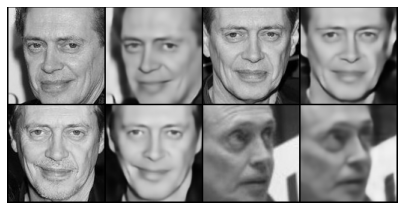

In [11]:
input_imgs = get_train_images(4)
print(input_imgs.shape)
visualize_reconstructions(testEn, testDe, input_imgs)